In [1]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm # Use notebook version for better display (used in predict_rewards)
from collections import deque # For observation history buffer
import glob # For finding checkpoints
from importnb import Notebook # For importing from other notebooks/scripts
import sys # For exiting gracefully
import cv2 # Needed for image decoding
import base64 # For decoding image from rpyc server
import io # For handling image bytes
import logging # For RemoteJetBot logging
import config
import models
from models import SimpleUNetV1
from transformers import CLIPProcessor, CLIPModel
with Notebook():
    from action_conditioned_diffusion_world_model_gemini import linear_beta_schedule, cosine_beta_schedule, get_index_from_list
    from jetbot_remote_client import RemoteJetBot

logger = logging.getLogger('MPC_Client')
logger.setLevel(logging.WARNING)
logging.basicConfig(level=logging.WARNING) # Set logging level (INFO, DEBUG, etc.)
logging.getLogger('matplotlib.font_manager').setLevel(logging.WARNING)


In [2]:
# --- JetBot Server Connection ---
JETBOT_SERVER_IP = "192.168.68.61" # <<< --- REPLACE WITH YOUR JETBOT'S ACTUAL IP ADDRESS
# Port identified from jetbot_server.py (uses rpyc)
JETBOT_SERVER_PORT = 18861

# --- Device Setup ---
device = torch.device(config.DEVICE if hasattr(config, 'DEVICE') else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# --- Model Paths ---
# World model path will be determined automatically by searching for 'model_best_epoch_*.pth'.

# Path to fine-tuned CLIP weights (ckpt-final folder)
CLIP_CKPT_PATH = r"C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\clip_kong_finetune\ckpt-final"
# Base model name you started from
CLIP_BASE_NAME = "openai/clip-vit-large-patch14"

# --- MPC Parameters ---
HORIZON = 5             # Planning horizon (number of steps to look ahead) H
N_ACTIONS = 1           # Dimensionality of the action space (RIGHT MOTOR ONLY)

# --- Discrete Actions ---
DISCRETE_ACTIONS = [0.0, 0.1] # The two possible actions

# --- Real Robot Parameters ---
REAL_ROBOT_FRAME_DELAY = 1.0 / 30.0 # Based on 30 FPS assumption
ACTION_SCALE = 1.0 # Keep for potential future use, but actions are discrete now

# --- Image Preprocessing (Matches config.TRANSFORM) ---
IMAGE_CHANNELS = 3 # Assuming 3 channels based on config.TRANSFORM and models
preprocess = transforms.Compose([
    # Note: Image received from get_frame is BGR numpy array.
    # Convert to RGB, then PIL, then transform.
    transforms.ToPILImage(), # Convert numpy array (RGB) to PIL Image
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization from config.TRANSFORM
])
# Inverse transform for visualization
denormalize = transforms.Compose([
    transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1/0.5, 1/0.5, 1/0.5]),
    transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1.0, 1.0, 1.0]),
])

# --- Diffusion Parameters (from config.py or defaults) ---
NUM_TIMESTEPS = getattr(config, 'NUM_TIMESTEPS', 10) # Use config value, default 10 based on log
BETA_START = getattr(config, 'BETA_START', 1e-4) #
BETA_END = getattr(config, 'BETA_END', 0.02) #
SCHEDULE_TYPE = getattr(config, 'SCHEDULE_TYPE', 'linear') #
NUM_PREV_FRAMES = config.NUM_PREV_FRAMES # Number of previous frames model expects

# --- Visualization Buffer ---
VISUALIZATION_BUFFER_SIZE = 50 # Store last N frames for visualization on exit

# %% [markdown]
# ## Diffusion Schedule Setup

# %%
# Calculate betas using imported functions
if SCHEDULE_TYPE == 'linear':
    betas = linear_beta_schedule(NUM_TIMESTEPS, BETA_START, BETA_END)
elif SCHEDULE_TYPE == 'cosine':
    betas = cosine_beta_schedule(NUM_TIMESTEPS)
else:
    raise ValueError(f"Unknown beta schedule: {SCHEDULE_TYPE}")

# Pre-calculate diffusion constants
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
# Ensure tensors are on the correct device
betas = betas.to(device)
alphas = alphas.to(device)
alphas_cumprod = alphas_cumprod.to(device)

## Interactive-review parameters
ADVANCE_MODE = "keypress"   # "keypress"  ➜ wait for Enter
                           # "delay"      ➜ pause WAIT_TIME seconds
WAIT_TIME    = 2.0          # seconds (used only if ADVANCE_MODE == "delay")

Using device: cuda


In [3]:
# --- Load World Model (SimpleUNetV1) ---
# Simplified Automatic Checkpoint Loading: Assumes at least one 'best' model exists.
checkpoint_to_load = None
loaded_config_from_checkpoint = None
world_model = None

# 1. Find the latest 'best' checkpoint file
# Use config for checkpoint directory
best_checkpoints = glob.glob(os.path.join(config.CHECKPOINT_DIR, 'model_best_epoch_*.pth'))
# Sort by epoch number (descending) to get the latest best
best_checkpoints.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]), reverse=True)
checkpoint_to_load = best_checkpoints[0] # Assume the list is not empty and take the first one
print(f"Attempting to load latest best world model checkpoint: {checkpoint_to_load}")

# 2. Load checkpoint metadata and instantiate the correct model
try:
    # Load directly without checking os.path.exists, assuming glob found a valid file
    checkpoint = torch.load(checkpoint_to_load, map_location=device)

    # --- Get Architecture Info from Checkpoint ---
    model_arch_name = None
    num_prev_frames_loaded = config.NUM_PREV_FRAMES # Default to current config
    time_emb_dim_loaded = getattr(config, 'TIME_EMB_DIM', 32) # Default

    if 'config' in checkpoint and checkpoint['config'] is not None: # Check if config exists and is not None
         loaded_config_from_checkpoint = checkpoint['config']
         if 'model_architecture' in loaded_config_from_checkpoint:
             model_arch_name = loaded_config_from_checkpoint['model_architecture']
             print(f"Checkpoint indicates model architecture: {model_arch_name}")
         if 'num_prev_frames' in loaded_config_from_checkpoint:
             num_prev_frames_loaded = loaded_config_from_checkpoint['num_prev_frames']
         if 'time_emb_dim' in loaded_config_from_checkpoint: # Check if time_emb_dim is saved
             time_emb_dim_loaded = loaded_config_from_checkpoint['time_emb_dim']
    else:
         # Fallback if checkpoint lacks architecture info - use current config
         print("Warning: Checkpoint missing config info or config is None. Using current config values.")
         model_arch_name = config.MODEL_ARCHITECTURE # Get from current config

    # --- Instantiate the model ---
    if model_arch_name and hasattr(models, model_arch_name):
         model_class = getattr(models, model_arch_name)

         # Ensure NUM_PREV_FRAMES matches between loaded model and current config expectation
         if num_prev_frames_loaded != config.NUM_PREV_FRAMES:
             print(f"Warning: Mismatch in NUM_PREV_FRAMES between loaded model ({num_prev_frames_loaded}) and current config ({config.NUM_PREV_FRAMES}). Using value from loaded model: {num_prev_frames_loaded}")
             # Update NUM_PREV_FRAMES globally to match the loaded model
             NUM_PREV_FRAMES = num_prev_frames_loaded
         else:
             print(f"Using NUM_PREV_FRAMES = {NUM_PREV_FRAMES}")


         world_model = model_class(
             image_channels=IMAGE_CHANNELS,
             time_emb_dim=time_emb_dim_loaded, # Use loaded or default
             num_prev_frames=NUM_PREV_FRAMES # Use potentially updated value
         ).to(device)
         print(f"Instantiated world model: {model_arch_name}")

         # --- Load State Dict ---
         world_model.load_state_dict(checkpoint['model_state_dict'])
         world_model.eval() # Set to evaluation mode
         print(f"Successfully loaded world model state from epoch {checkpoint.get('epoch', 'N/A')}.")

    else:
         print(f"ERROR: Model class '{model_arch_name}' not found in models.py or could not be determined!")
         world_model = None # Ensure model is None if instantiation failed

except FileNotFoundError:
    # This error might still occur if the file path from glob is somehow invalid later
    print(f"Error: World model checkpoint file not found at path: {checkpoint_to_load}")
    world_model = None
except KeyError as e:
    print(f"Error loading world model checkpoint (KeyError: {e}). Checkpoint structure might be different.")
    world_model = None
except Exception as e:
     print(f"An unexpected error occurred loading world model checkpoint {checkpoint_to_load}: {e}.")
     world_model = None


# Ensure model is loaded before proceeding
if world_model is None:
    print("World model could not be loaded. Exiting.")
    sys.exit(1) # Exit script
else:
    print(f"Using World Model: {world_model.__class__.__name__}")

for param in world_model.parameters():
    param.requires_grad = False

Attempting to load latest best world model checkpoint: C:\Projects\jetbot-diffusion-world-model-kong-finder-aux\output_model_small_session_split_data\checkpoints\model_best_epoch_70.pth
Checkpoint indicates model architecture: SimpleUNetV1
Using NUM_PREV_FRAMES = 4
Instantiated world model: SimpleUNetV1
Successfully loaded world model state from epoch 70.
Using World Model: SimpleUNetV1


In [4]:
# --- Load Reward Model (CLIP) ---
processor   = CLIPProcessor.from_pretrained(CLIP_BASE_NAME)
clip_model  = CLIPModel.from_pretrained(CLIP_CKPT_PATH, torch_dtype=torch.float16).eval().to(device)

POS_PROMPT = "a red object on the ground"
NEG_PROMPT = "a kitchen floor with no red object on the ground"

with torch.no_grad():
    pos_emb = clip_model.get_text_features(**processor(text=POS_PROMPT,
                                                       return_tensors="pt").to(device)).float()
    neg_emb = clip_model.get_text_features(**processor(text=NEG_PROMPT,
                                                       return_tensors="pt").to(device)).float()
    pos_emb /= pos_emb.norm(dim=-1, keepdim=True)
    neg_emb /= neg_emb.norm(dim=-1, keepdim=True)

def clip_reward_batch(img_batch, tau: float = 5.0):
    """
    img_batch : (B, 3, H, W) in [-1,1]  –> returns (B,) reward in [0,1]
    """
    # Map from [-1,1] → processor expects [0,1] float
    imgs = (img_batch * 0.5 + 0.5).clamp(0, 1)
    with torch.no_grad():
        inputs   = processor(images=imgs, return_tensors="pt").to(device)
        img_emb  = clip_model.get_image_features(**inputs).float()
        img_emb /= img_emb.norm(dim=-1, keepdim=True)
        delta    = (img_emb @ pos_emb.T) - (img_emb @ neg_emb.T)   # (B,1)
        return torch.sigmoid(tau * delta).squeeze(1)              # (B,)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/preprocessor_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/tokenizer_config.json HTTP/11" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/processor_config.json HTTP/11" 404 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /openai/clip-vit-large-patch14/resolve/main/chat_template.json HTTP/11" 404 0
DEBUG:urllib3.connect

In [5]:
remote_robot = None # Initialize variable
try:
    # Use the imported RemoteJetBot class
    remote_robot = RemoteJetBot(JETBOT_SERVER_IP)
    # Connection happens in __init__
    time.sleep(1.0) # Give connection time to stabilize
except Exception as e:
     logger.error(f"Failed to initialize RemoteJetBot: {e}")
     sys.exit(1)


INFO:JetBotClient:Connecting to JetBot at 192.168.68.61:18861
INFO:JetBotClient:Connected successfully!


Image(value=b'', format='jpeg', height='300', width='400')

In [6]:
def get_observation_real():
    """Captures an image via RPyC and preprocesses it."""
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for get_observation_real.")
        return None

    try:
        # Use the get_frame method from the imported class
        image_bgr = remote_robot.get_frame() # Returns BGR numpy array or None

        if image_bgr is None or image_bgr.size == 0:
             logger.warning("Received invalid/empty image frame from remote robot.")
             return None

        # Convert BGR numpy array to RGB for preprocessing
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Preprocess (includes ToPILImage, Resize, ToTensor, Normalize)
        obs_tensor = preprocess(image_rgb).to(device)
        return obs_tensor

    except Exception as e:
        logger.error(f"Error during get_observation_real: {e}")
        return None


def apply_action_real(right_motor_action):
    """Sends the action to the JetBot via RPyC."""
    if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
        logger.error("RPyC connection not available for apply_action_real.")
        return

    try:
        right_motor_speed = float(right_motor_action) * ACTION_SCALE
        left_motor_speed = 0.0 # Keep left motor off

        # Clamping (optional, server might also clamp)
        right_motor_speed = max(min(right_motor_speed, 1.0), -1.0)

        # Use the set_motors method from the imported class
        success = remote_robot.set_motors(left_motor_speed, right_motor_speed)
        # Optional: Check success flag if needed

        # Wait for the frame delay *after* sending the command
        time.sleep(REAL_ROBOT_FRAME_DELAY)

    except Exception as e:
        logger.error(f"Error during RPyC apply_action_real: {e}")

def sample_next_obs(world_model, obs_buffer, action_scalar):
    """
    Diffusion-sample the *next* frame given the current observation history
    and a (scalar) action. Returns a (3,H,W) tensor in [-1,1].
    """
    prev_frames = format_prev_frames(obs_buffer)
    if prev_frames is None:
        return None

    prev_frames = prev_frames.unsqueeze(0)                    # (1, 3*K, H, W)
    action_batch = torch.tensor([[action_scalar]],
                                device=device, dtype=torch.float32)
    x = torch.randn((1, IMAGE_CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE),
                    device=device)

    with torch.no_grad():
        for i in reversed(range(NUM_TIMESTEPS)):
            t = torch.tensor([i], device=device, dtype=torch.long)
            alpha_t      = get_index_from_list(alphas,         t, x.shape)
            alpha_hat_t  = get_index_from_list(alphas_cumprod, t, x.shape)
            beta_t       = get_index_from_list(betas,          t, x.shape)

            eps = world_model(x=x,
                              timestep=t,
                              action=action_batch,
                              prev_frames=prev_frames)

            x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t)
                   / torch.sqrt(1 - alpha_hat_t)) * eps)

            if i > 0:
                x = x + torch.sqrt(beta_t) * torch.randn_like(x)

    return torch.clamp(x.squeeze(0), -1.0, 1.0)               # (3,H,W)


def review_step(curr_obs, curr_reward,
                pred_frames, pred_rewards,
                chosen_action):
    """
    Display the current frame + one-step predictions for both discrete actions,
    then wait according to ADVANCE_MODE.
    """
    f0, f1           = pred_frames
    r0, r1           = pred_rewards
    imgs             = [curr_obs, f0, f1]
    titles           = [f"Current  (r={curr_reward:.3f})",
                        f"Next a={DISCRETE_ACTIONS[0]} (r={r0:.3f})",
                        f"Next a={DISCRETE_ACTIONS[1]} (r={r1:.3f})"]

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    for ax, img, title in zip(axes, imgs, titles):
        img_disp = denormalize(img.detach().cpu())
        ax.imshow(np.clip(img_disp.permute(1,2,0).numpy(), 0, 1))
        ax.set_title(title); ax.axis("off")
    plt.suptitle(f"Chosen action for *this* step → {chosen_action}")
    plt.show()

    if ADVANCE_MODE == "keypress":
        _ = input("Press <Enter> to continue …")
    else:                             # "delay"
        time.sleep(WAIT_TIME)

In [7]:
def format_prev_frames(obs_buffer):
    """ Concatenates previous frames from buffer for model input. """
    # Use the globally determined NUM_PREV_FRAMES
    if len(obs_buffer) < NUM_PREV_FRAMES:
         # This should ideally not happen after initialization
         print(f"Error: Observation buffer has {len(obs_buffer)} frames, needs {NUM_PREV_FRAMES} for prev_frames.")
         return None # Indicate error

    # Get the NUM_PREV_FRAMES most recent observations *excluding the latest one*
    prev_frames_list = list(obs_buffer)[-(NUM_PREV_FRAMES + 1):-1]
    # Concatenate along the channel dimension (C) -> (C*num_prev, H, W)
    prev_frames_tensor = torch.cat(prev_frames_list, dim=0)
    return prev_frames_tensor


def predict_rewards(world_model, initial_obs_buffer_list, action_sequences_batch):
    """
    Predicts the cumulative reward for a batch of action sequences using the
    diffusion world model and reward model. Uses real previous frames history.

    Args:
        world_model: The SimpleUNetV1 model.
        initial_obs_buffer_list (list): List of initial observation tensors,
                                        size NUM_PREV_FRAMES + 1.
        action_sequences_batch (torch.Tensor): Batch of action sequences (B, H, N_ACTIONS=1).

    Returns:
        torch.Tensor: Predicted cumulative rewards for each sequence (B,).
    """
    batch_size, horizon, num_actions = action_sequences_batch.shape
    total_rewards = torch.zeros(batch_size, device=device)

    # Ensure models are in evaluation mode
    world_model.eval()

    # --- Initialize hypothetical observation buffers for each sample in the batch ---
    hypothetical_buffers = [deque(initial_obs_buffer_list, maxlen=NUM_PREV_FRAMES + 1) for _ in range(batch_size)]

    with torch.no_grad():
        for h_step in range(horizon):
            actions_t = action_sequences_batch[:, h_step, :] # Actions for this horizon step (B, 1)

            # --- Prepare inputs for the batch ---
            batch_prev_frames_list = []
            for i in range(batch_size):
                # Use the globally determined NUM_PREV_FRAMES here
                prev_frames = format_prev_frames(hypothetical_buffers[i])
                if prev_frames is None:
                    print(f"Error: Could not format prev_frames for batch sample {i} at horizon {h_step}")
                    return torch.full((batch_size,), -float('inf'), device=device) # Return very low reward on error
                batch_prev_frames_list.append(prev_frames)

            batch_prev_frames_tensor = torch.stack(batch_prev_frames_list, dim=0)

            # --- Predict next observation using DDPM sampling loop for the batch ---
            x = torch.randn((batch_size, IMAGE_CHANNELS, config.IMAGE_SIZE, config.IMAGE_SIZE), device=device)

            # Inner loop for diffusion steps
            for i in reversed(range(0, NUM_TIMESTEPS)):
                t_val = i
                t = torch.full((batch_size,), t_val, device=device, dtype=torch.long)

                # Use imported get_index_from_list
                alpha_t = get_index_from_list(alphas, t, x.shape)
                alpha_hat_t = get_index_from_list(alphas_cumprod, t, x.shape)
                beta_t = get_index_from_list(betas, t, x.shape)

                predicted_noise = world_model(x=x, timestep=t, action=actions_t, prev_frames=batch_prev_frames_tensor)

                term1 = 1 / torch.sqrt(alpha_t)
                term2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
                x = term1 * (x - term2 * predicted_noise)

                if t_val > 0:
                    noise = torch.randn_like(x)
                    variance = torch.sqrt(beta_t)
                    x = x + variance * noise

            predicted_obs_batch = torch.clamp(x, -1.0, 1.0)

            # --- Predict reward ---
            rewards_t = clip_reward_batch(predicted_obs_batch)

            if torch.isnan(rewards_t).any() or torch.isinf(rewards_t).any():
                print(f"Warning: NaN/Inf detected in predicted rewards at horizon step {h_step}. Replacing with 0.")
                rewards_t = torch.nan_to_num(rewards_t, nan=0.0, posinf=0.0, neginf=0.0)

            total_rewards += rewards_t

            # --- Update hypothetical buffers ---
            for i in range(batch_size):
                 hypothetical_buffers[i].append(predicted_obs_batch[i])

    return total_rewards


def choose_best_action(world_model, current_obs_buffer_list):
    """
    Chooses the best discrete action (0.0 or 0.1) by predicting rewards
    for constant action sequences over the horizon.

    Args:
        world_model: The SimpleUNetV1 model.
        current_obs_buffer_list (list): The current observation buffer list
                                       (size NUM_PREV_FRAMES + 1).

    Returns:
        float: The best discrete action (0.0 or 0.1).
        tuple: Predicted rewards for (action 0.0, action 0.1)
    """
    # Use the globally determined NUM_PREV_FRAMES
    if len(current_obs_buffer_list) != NUM_PREV_FRAMES + 1:
        print(f"Error: Action selection requires a full observation buffer ({NUM_PREV_FRAMES + 1} frames). Got {len(current_obs_buffer_list)}.")
        return DISCRETE_ACTIONS[0], (-float('inf'), -float('inf')) # Return default stop action and invalid rewards

    # --- Create the two constant action sequences ---
    action_seq_0 = torch.full((1, HORIZON, N_ACTIONS), DISCRETE_ACTIONS[0], device=device, dtype=torch.float32)
    action_seq_1 = torch.full((1, HORIZON, N_ACTIONS), DISCRETE_ACTIONS[1], device=device, dtype=torch.float32)

    # --- Predict rewards for both sequences ---
    # Calling predict_rewards twice
    reward_0 = predict_rewards(world_model, current_obs_buffer_list, action_seq_0)
    reward_1 = predict_rewards(world_model, current_obs_buffer_list, action_seq_1)

    # --- Compare rewards and choose action ---
    reward_0_val = reward_0.item() if torch.isfinite(reward_0).all() else -float('inf')
    reward_1_val = reward_1.item() if torch.isfinite(reward_1).all() else -float('inf')

    # **ADDED PRINT STATEMENT**
    print(f"  Predicted Rewards -> Action {DISCRETE_ACTIONS[0]}: {reward_0_val:.4f} | Action {DISCRETE_ACTIONS[1]}: {reward_1_val:.4f}")

    if reward_1_val > reward_0_val:
        best_action = DISCRETE_ACTIONS[1] # Action 0.1
    else:
        # Default to 0.0 if rewards are equal or 0.1 is not better
        best_action = DISCRETE_ACTIONS[0] # Action 0.0

    # **ADDED PRINT STATEMENT**
    print(f"  ==> Chosen Action: {best_action}")
    return best_action, (reward_0_val, reward_1_val) # Return chosen action and predicted rewards


Starting Continuous MPC Control Loop (interactive)…
  1/5
  2/5
  3/5
  4/5
  5/5

─── Step 1 ───


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


  Predicted Rewards -> Action 0.0: 2.4996 | Action 0.1: 2.4939
  ==> Chosen Action: 0.0


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


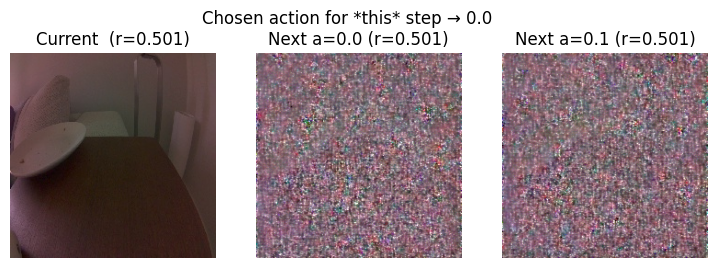

Press <Enter> to continue … 


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully



─── Step 2 ───
  Predicted Rewards -> Action 0.0: 2.4977 | Action 0.1: 2.5030
  ==> Chosen Action: 0.1


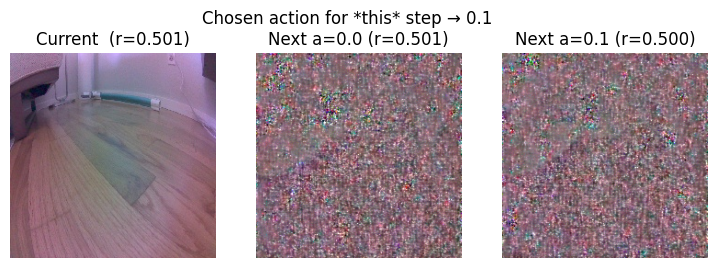

Press <Enter> to continue … 


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully



─── Step 3 ───
  Predicted Rewards -> Action 0.0: 2.4936 | Action 0.1: 2.5057
  ==> Chosen Action: 0.1


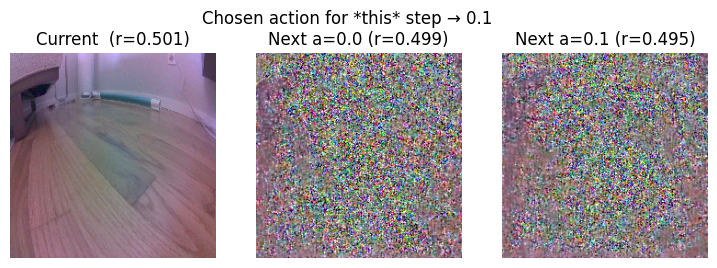

Press <Enter> to continue … 


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully



─── Step 4 ───
  Predicted Rewards -> Action 0.0: 2.4985 | Action 0.1: 2.4875
  ==> Chosen Action: 0.0


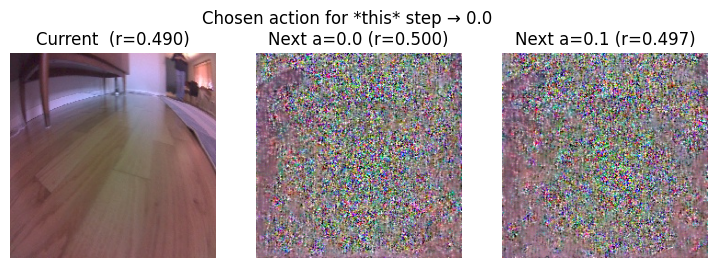

DEBUG:JetBotClient:Cleaning up connection
DEBUG:JetBotClient:Sending motor command: left=0, right=0
DEBUG:JetBotClient:Command sent successfully
INFO:JetBotClient:Cleanup completed



KeyboardInterrupt – exiting loop.
Finished after 4 steps (50.4s).


In [8]:
print("Starting Continuous MPC Control Loop (interactive)…")

observation_buffer   = deque(maxlen=NUM_PREV_FRAMES + 1)
visualization_buffer = deque(maxlen=VISUALIZATION_BUFFER_SIZE)

# --- bootstrap buffer -------------------------------------------------------
print(f"Collecting {NUM_PREV_FRAMES + 1} initial observations …")
while len(observation_buffer) < NUM_PREV_FRAMES + 1:
    obs = get_observation_real()
    if obs is not None:
        observation_buffer.append(obs)
        visualization_buffer.append(obs.cpu().numpy())
        print(f"  {len(observation_buffer)}/{NUM_PREV_FRAMES + 1}")
    time.sleep(0.05)

# --- interactive MPC loop ---------------------------------------------------
step_count    = 0
start_wall_ts = time.time()

try:
    while True:
        step_count += 1
        print(f"\n─── Step {step_count} ───")

        # --------------------------------------------------------------------
        # 1. Plan action (unchanged logic)
        best_action, (rew0, rew1) = choose_best_action(
            world_model, list(observation_buffer))

        # --------------------------------------------------------------------
        # 2. Gather display data BEFORE executing the action
        curr_obs     = observation_buffer[-1]
        curr_reward  = clip_reward_batch(curr_obs.unsqueeze(0)).item()

        pred_frame_0 = sample_next_obs(world_model, observation_buffer,
                                       DISCRETE_ACTIONS[0])
        pred_frame_1 = sample_next_obs(world_model, observation_buffer,
                                       DISCRETE_ACTIONS[1])
        pred_rew_0   = clip_reward_batch(pred_frame_0.unsqueeze(0)).item()
        pred_rew_1   = clip_reward_batch(pred_frame_1.unsqueeze(0)).item()

        # --------------------------------------------------------------------
        # 3. Show everything & pause
        review_step(curr_obs, curr_reward,
                    (pred_frame_0, pred_frame_1),
                    (pred_rew_0,  pred_rew_1),
                    best_action)

        # --------------------------------------------------------------------
        # 4. Apply chosen action
        apply_action_real(best_action)

        # --------------------------------------------------------------------
        # 5. Observe next real frame
        next_obs = get_observation_real()
        if next_obs is not None:
            observation_buffer.append(next_obs)
            visualization_buffer.append(next_obs.cpu().numpy())
        else:
            logger.warning("Failed to grab frame after action.")

except KeyboardInterrupt:
    print("\nKeyboardInterrupt – exiting loop.")
finally:
    if remote_robot:
        remote_robot.cleanup()
    print(f"Finished after {step_count} steps "
          f"({time.time()-start_wall_ts:.1f}s).")

Starting Continuous MPC Control Loop...
Collected initial observation 1/5
Collected initial observation 2/5
Collected initial observation 3/5
Collected initial observation 4/5
Collected initial observation 5/5
Initial observation buffer filled. Starting continuous control.

--- Step 1 ---
Planning action...


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1


  Predicted Rewards -> Action 0.0: 2.4889 | Action 0.1: 2.5031
  ==> Chosen Action: 0.1
Planning finished in 1.971s
Applying action: 0.1


DEBUG:JetBotClient:Command sent successfully


Step 1 Summary | Plan Time: 1.971s | Step Time: 2.368s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.489, 2.503)

--- Step 2 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4988 | Action 0.1: 2.5084
  ==> Chosen Action: 0.1
Planning finished in 1.031s
Applying action: 0.1
Step 2 Summary | Plan Time: 1.031s | Step Time: 1.217s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.499, 2.508)

--- Step 3 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5128 | Action 0.1: 2.5141
  ==> Chosen Action: 0.1
Planning finished in 0.967s
Applying action: 0.1
Step 3 Summary | Plan Time: 0.967s | Step Time: 1.100s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.513, 2.514)

--- Step 4 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5150 | Action 0.1: 2.5283
  ==> Chosen Action: 0.1
Planning finished in 1.020s
Applying action: 0.1
Step 4 Summary | Plan Time: 1.020s | Step Time: 1.129s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.515, 2.528)

--- Step 5 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5375 | Action 0.1: 2.5318
  ==> Chosen Action: 0.0
Planning finished in 0.972s
Applying action: 0.0
Step 5 Summary | Plan Time: 0.972s | Step Time: 1.184s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.537, 2.532)

--- Step 6 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5052 | Action 0.1: 2.5129
  ==> Chosen Action: 0.1
Planning finished in 1.013s
Applying action: 0.1
Step 6 Summary | Plan Time: 1.013s | Step Time: 1.229s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.505, 2.513)

--- Step 7 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1


  Predicted Rewards -> Action 0.0: 2.5184 | Action 0.1: 2.5371
  ==> Chosen Action: 0.1
Planning finished in 1.079s
Applying action: 0.1


DEBUG:JetBotClient:Command sent successfully


Step 7 Summary | Plan Time: 1.079s | Step Time: 1.591s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.518, 2.537)

--- Step 8 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5073 | Action 0.1: 2.4989
  ==> Chosen Action: 0.0
Planning finished in 1.059s
Applying action: 0.0
Step 8 Summary | Plan Time: 1.059s | Step Time: 1.270s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.507, 2.499)

--- Step 9 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4974 | Action 0.1: 2.4853
  ==> Chosen Action: 0.0
Planning finished in 1.063s
Applying action: 0.0
Step 9 Summary | Plan Time: 1.063s | Step Time: 1.498s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.497, 2.485)

--- Step 10 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0


  Predicted Rewards -> Action 0.0: 2.4939 | Action 0.1: 2.4892
  ==> Chosen Action: 0.0
Planning finished in 1.040s
Applying action: 0.0


DEBUG:JetBotClient:Command sent successfully


Step 10 Summary | Plan Time: 1.040s | Step Time: 1.471s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.494, 2.489)

--- Step 11 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1


  Predicted Rewards -> Action 0.0: 2.4929 | Action 0.1: 2.4982
  ==> Chosen Action: 0.1
Planning finished in 1.058s
Applying action: 0.1


DEBUG:JetBotClient:Command sent successfully


Step 11 Summary | Plan Time: 1.058s | Step Time: 1.350s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.493, 2.498)

--- Step 12 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4930 | Action 0.1: 2.4955
  ==> Chosen Action: 0.1
Planning finished in 1.014s
Applying action: 0.1
Step 12 Summary | Plan Time: 1.014s | Step Time: 1.150s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.493, 2.496)

--- Step 13 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4944 | Action 0.1: 2.5040
  ==> Chosen Action: 0.1
Planning finished in 0.996s
Applying action: 0.1
Step 13 Summary | Plan Time: 0.996s | Step Time: 1.120s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.494, 2.504)

--- Step 14 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4942 | Action 0.1: 2.4990
  ==> Chosen Action: 0.1
Planning finished in 1.010s
Applying action: 0.1
Step 14 Summary | Plan Time: 1.010s | Step Time: 1.131s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.494, 2.499)

--- Step 15 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4930 | Action 0.1: 2.4984
  ==> Chosen Action: 0.1
Planning finished in 0.987s
Applying action: 0.1
Step 15 Summary | Plan Time: 0.987s | Step Time: 1.119s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.493, 2.498)

--- Step 16 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4850 | Action 0.1: 2.5086
  ==> Chosen Action: 0.1
Planning finished in 0.981s
Applying action: 0.1
Step 16 Summary | Plan Time: 0.981s | Step Time: 1.135s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.485, 2.509)

--- Step 17 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4987 | Action 0.1: 2.4918
  ==> Chosen Action: 0.0
Planning finished in 0.986s
Applying action: 0.0
Step 17 Summary | Plan Time: 0.986s | Step Time: 1.189s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.499, 2.492)

--- Step 18 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5009 | Action 0.1: 2.4925
  ==> Chosen Action: 0.0
Planning finished in 1.069s
Applying action: 0.0
Step 18 Summary | Plan Time: 1.069s | Step Time: 1.165s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.501, 2.493)

--- Step 19 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4984 | Action 0.1: 2.5025
  ==> Chosen Action: 0.1
Planning finished in 1.025s
Applying action: 0.1
Step 19 Summary | Plan Time: 1.025s | Step Time: 1.182s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.498, 2.502)

--- Step 20 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5030 | Action 0.1: 2.4845
  ==> Chosen Action: 0.0
Planning finished in 1.013s
Applying action: 0.0
Step 20 Summary | Plan Time: 1.013s | Step Time: 1.244s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.503, 2.484)

--- Step 21 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4984 | Action 0.1: 2.4979
  ==> Chosen Action: 0.0
Planning finished in 1.074s
Applying action: 0.0
Step 21 Summary | Plan Time: 1.074s | Step Time: 1.157s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.498, 2.498)

--- Step 22 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5082 | Action 0.1: 2.4965
  ==> Chosen Action: 0.0
Planning finished in 0.995s
Applying action: 0.0
Step 22 Summary | Plan Time: 0.995s | Step Time: 1.128s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.508, 2.497)

--- Step 23 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5070 | Action 0.1: 2.5086
  ==> Chosen Action: 0.1
Planning finished in 1.014s
Applying action: 0.1
Step 23 Summary | Plan Time: 1.014s | Step Time: 1.186s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.507, 2.509)

--- Step 24 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4986 | Action 0.1: 2.4955
  ==> Chosen Action: 0.0
Planning finished in 0.983s
Applying action: 0.0
Step 24 Summary | Plan Time: 0.983s | Step Time: 1.188s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.499, 2.496)

--- Step 25 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5076 | Action 0.1: 2.5289
  ==> Chosen Action: 0.1
Planning finished in 0.998s
Applying action: 0.1
Step 25 Summary | Plan Time: 0.998s | Step Time: 1.137s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.508, 2.529)

--- Step 26 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4950 | Action 0.1: 2.5073
  ==> Chosen Action: 0.1
Planning finished in 1.017s
Applying action: 0.1
Step 26 Summary | Plan Time: 1.017s | Step Time: 1.095s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.495, 2.507)

--- Step 27 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5020 | Action 0.1: 2.4970
  ==> Chosen Action: 0.0
Planning finished in 1.083s
Applying action: 0.0
Step 27 Summary | Plan Time: 1.083s | Step Time: 1.292s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.502, 2.497)

--- Step 28 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4921 | Action 0.1: 2.5003
  ==> Chosen Action: 0.1
Planning finished in 0.990s
Applying action: 0.1
Step 28 Summary | Plan Time: 0.990s | Step Time: 1.125s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.492, 2.500)

--- Step 29 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5137 | Action 0.1: 2.5007
  ==> Chosen Action: 0.0
Planning finished in 0.982s
Applying action: 0.0
Step 29 Summary | Plan Time: 0.982s | Step Time: 1.128s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.514, 2.501)

--- Step 30 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4822 | Action 0.1: 2.4986
  ==> Chosen Action: 0.1
Planning finished in 1.041s
Applying action: 0.1
Step 30 Summary | Plan Time: 1.041s | Step Time: 1.235s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.482, 2.499)

--- Step 31 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4938 | Action 0.1: 2.5126
  ==> Chosen Action: 0.1
Planning finished in 1.039s
Applying action: 0.1
Step 31 Summary | Plan Time: 1.039s | Step Time: 1.161s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.494, 2.513)

--- Step 32 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5016 | Action 0.1: 2.4923
  ==> Chosen Action: 0.0
Planning finished in 1.106s
Applying action: 0.0
Step 32 Summary | Plan Time: 1.106s | Step Time: 1.323s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.502, 2.492)

--- Step 33 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5026 | Action 0.1: 2.4941
  ==> Chosen Action: 0.0
Planning finished in 1.120s
Applying action: 0.0
Step 33 Summary | Plan Time: 1.120s | Step Time: 1.253s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.503, 2.494)

--- Step 34 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4956 | Action 0.1: 2.4977
  ==> Chosen Action: 0.1
Planning finished in 1.016s
Applying action: 0.1
Step 34 Summary | Plan Time: 1.016s | Step Time: 1.183s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.496, 2.498)

--- Step 35 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4974 | Action 0.1: 2.4991
  ==> Chosen Action: 0.1
Planning finished in 1.000s
Applying action: 0.1
Step 35 Summary | Plan Time: 1.000s | Step Time: 1.167s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.497, 2.499)

--- Step 36 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4975 | Action 0.1: 2.4917
  ==> Chosen Action: 0.0
Planning finished in 1.012s
Applying action: 0.0
Step 36 Summary | Plan Time: 1.012s | Step Time: 1.173s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.497, 2.492)

--- Step 37 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5055 | Action 0.1: 2.4988
  ==> Chosen Action: 0.0
Planning finished in 0.997s
Applying action: 0.0
Step 37 Summary | Plan Time: 0.997s | Step Time: 1.072s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.505, 2.499)

--- Step 38 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4969 | Action 0.1: 2.4990
  ==> Chosen Action: 0.1
Planning finished in 1.005s
Applying action: 0.1
Step 38 Summary | Plan Time: 1.005s | Step Time: 1.182s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.497, 2.499)

--- Step 39 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5052 | Action 0.1: 2.5049
  ==> Chosen Action: 0.0
Planning finished in 1.036s
Applying action: 0.0
Step 39 Summary | Plan Time: 1.036s | Step Time: 1.228s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.505, 2.505)

--- Step 40 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5071 | Action 0.1: 2.4985
  ==> Chosen Action: 0.0
Planning finished in 1.034s
Applying action: 0.0
Step 40 Summary | Plan Time: 1.034s | Step Time: 1.177s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.507, 2.499)

--- Step 41 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4936 | Action 0.1: 2.5018
  ==> Chosen Action: 0.1
Planning finished in 1.010s
Applying action: 0.1
Step 41 Summary | Plan Time: 1.010s | Step Time: 1.185s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.494, 2.502)

--- Step 42 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4944 | Action 0.1: 2.4985
  ==> Chosen Action: 0.1
Planning finished in 1.017s
Applying action: 0.1
Step 42 Summary | Plan Time: 1.017s | Step Time: 1.242s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.494, 2.499)

--- Step 43 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4994 | Action 0.1: 2.5001
  ==> Chosen Action: 0.1
Planning finished in 1.011s
Applying action: 0.1
Step 43 Summary | Plan Time: 1.011s | Step Time: 1.208s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.499, 2.500)

--- Step 44 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4984 | Action 0.1: 2.4967
  ==> Chosen Action: 0.0
Planning finished in 1.011s
Applying action: 0.0
Step 44 Summary | Plan Time: 1.011s | Step Time: 1.234s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.498, 2.497)

--- Step 45 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5074 | Action 0.1: 2.5047
  ==> Chosen Action: 0.0
Planning finished in 1.026s
Applying action: 0.0
Step 45 Summary | Plan Time: 1.026s | Step Time: 1.176s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.507, 2.505)

--- Step 46 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4970 | Action 0.1: 2.5004
  ==> Chosen Action: 0.1
Planning finished in 1.019s
Applying action: 0.1
Step 46 Summary | Plan Time: 1.019s | Step Time: 1.190s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.497, 2.500)

--- Step 47 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5188 | Action 0.1: 2.4980
  ==> Chosen Action: 0.0
Planning finished in 1.030s
Applying action: 0.0
Step 47 Summary | Plan Time: 1.030s | Step Time: 1.257s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.519, 2.498)

--- Step 48 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.4944 | Action 0.1: 2.4963
  ==> Chosen Action: 0.1
Planning finished in 1.006s
Applying action: 0.1
Step 48 Summary | Plan Time: 1.006s | Step Time: 1.203s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.494, 2.496)

--- Step 49 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0


  Predicted Rewards -> Action 0.0: 2.5018 | Action 0.1: 2.4948
  ==> Chosen Action: 0.0
Planning finished in 1.014s
Applying action: 0.0


DEBUG:JetBotClient:Command sent successfully


Step 49 Summary | Plan Time: 1.014s | Step Time: 1.520s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.502, 2.495)

--- Step 50 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.1


  Predicted Rewards -> Action 0.0: 2.4975 | Action 0.1: 2.5047
  ==> Chosen Action: 0.1
Planning finished in 1.047s
Applying action: 0.1


DEBUG:JetBotClient:Command sent successfully


Step 50 Summary | Plan Time: 1.047s | Step Time: 1.367s | Chosen Action: R=0.1 | Pred Rewards (0.0, 0.1): (2.498, 2.505)

--- Step 51 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0


  Predicted Rewards -> Action 0.0: 2.5023 | Action 0.1: 2.5012
  ==> Chosen Action: 0.0
Planning finished in 0.999s
Applying action: 0.0


DEBUG:JetBotClient:Command sent successfully


Step 51 Summary | Plan Time: 0.999s | Step Time: 1.589s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.502, 2.501)

--- Step 52 ---
Planning action...


DEBUG:JetBotClient:Sending motor command: left=0.0, right=0.0
DEBUG:JetBotClient:Command sent successfully


  Predicted Rewards -> Action 0.0: 2.5001 | Action 0.1: 2.4987
  ==> Chosen Action: 0.0
Planning finished in 1.015s
Applying action: 0.0
Step 52 Summary | Plan Time: 1.015s | Step Time: 1.357s | Chosen Action: R=0.0 | Pred Rewards (0.0, 0.1): (2.500, 2.499)

--- Step 53 ---
Planning action...


DEBUG:JetBotClient:Cleaning up connection
DEBUG:JetBotClient:Sending motor command: left=0, right=0
DEBUG:JetBotClient:Command sent successfully
INFO:JetBotClient:Cleanup completed
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Projects\\pythonenv-deeprl\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Projects\\pythonenv-deeprl\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stre


KeyboardInterrupt received. Stopping control loop.
Shutting down remote connection...
Remote connection closed.

===== MPC Control Loop Finished =====
Ran for 53 steps.
Total Duration: 00:01:05

Visualizing last 50 captured observations...


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\cambriaz.ttf', name='Cambria', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BROADW.TTF', name='Broadway', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\LTYPE.TTF', name='Lucida Sans Typewriter', style='normal', variant='normal', weight=400, stretch='norma

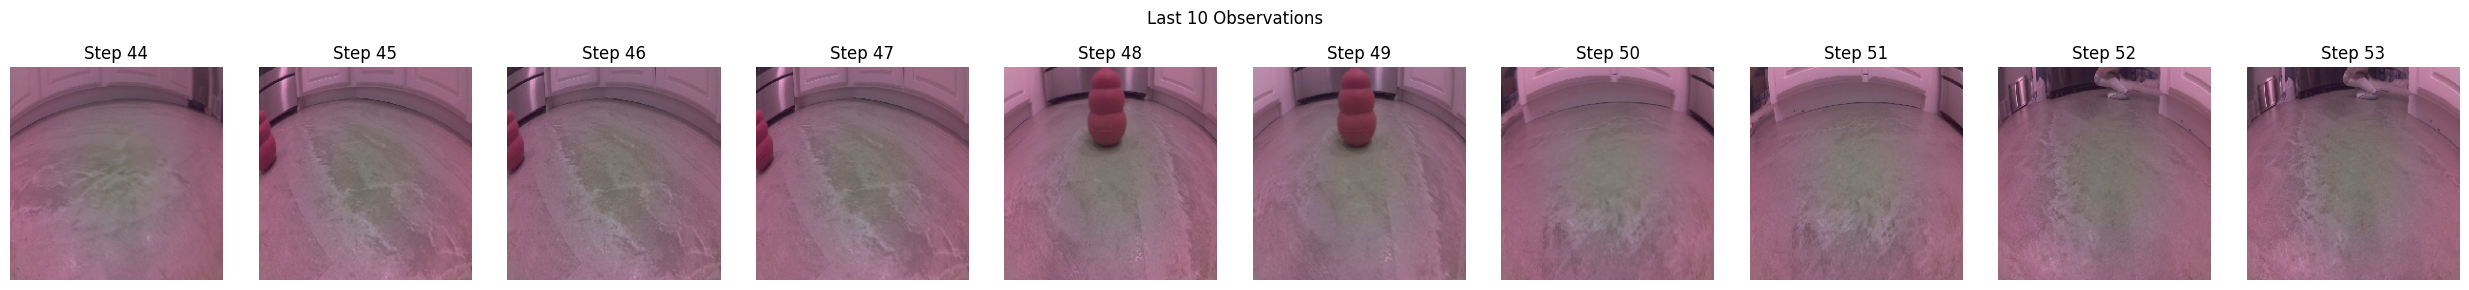

In [8]:
print("Starting Continuous MPC Control Loop...")
# --- Initialize Observation Buffers ---
# Use the globally determined NUM_PREV_FRAMES
observation_buffer = deque(maxlen=NUM_PREV_FRAMES + 1)
visualization_buffer = deque(maxlen=VISUALIZATION_BUFFER_SIZE) # For storing recent frames for display

print(f"Collecting {NUM_PREV_FRAMES + 1} initial observations...")
initial_obs_collected = 0
while initial_obs_collected < NUM_PREV_FRAMES + 1:
    obs = get_observation_real()
    if obs is not None:
        observation_buffer.append(obs) # Add tensor (C, H, W)
        visualization_buffer.append(obs.cpu().numpy()) # Add numpy version for vis
        initial_obs_collected += 1
        print(f"Collected initial observation {initial_obs_collected}/{NUM_PREV_FRAMES + 1}")
    else:
        print("Failed to get initial observation, retrying...")
        time.sleep(0.5)
    # Add a small delay to avoid overwhelming the server/network
    time.sleep(0.05) # Shorter delay between initial captures

if len(observation_buffer) != NUM_PREV_FRAMES + 1:
     print("Error: Could not collect enough initial observations. Exiting.")
     if 'remote_robot' in locals() and remote_robot:
         remote_robot.cleanup() # Use the cleanup method
     sys.exit(1) # Exit script
else:
     print("Initial observation buffer filled. Starting continuous control.")


# --- Main Control Loop ---
step_count = 0
start_run_time = time.time()
try:
    while True: # Run indefinitely until interrupted
        step_start_time = time.time()

        # Check RPyC connection before planning/acting
        if remote_robot is None or remote_robot.conn is None or remote_robot.conn.closed:
             logger.error("RPyC connection lost. Stopping control loop.")
             break

        step_count += 1
        print(f"\n--- Step {step_count} ---") # **ADDED PRINT STATEMENT**

        # 1. Plan the best action by comparing discrete options
        print("Planning action...") # **ADDED PRINT STATEMENT**
        plan_start_time = time.time()
        # Pass the current buffer (as a list) to the optimizer/chooser
        # **MODIFIED: Get predicted rewards back**
        action_val, predicted_rewards_tuple = choose_best_action(world_model, list(observation_buffer))
        plan_duration = time.time() - plan_start_time
        print(f"Planning finished in {plan_duration:.3f}s") # **ADDED PRINT STATEMENT**

        # 2. Apply the chosen action (right motor only) via RPyC
        print(f"Applying action: {action_val:.1f}") # **ADDED PRINT STATEMENT**
        apply_action_real(action_val)

        # 3. Get the next observation via RPyC
        # print("Getting next observation...") # Optional print
        next_obs_tensor = get_observation_real()
        if next_obs_tensor is None:
            logger.warning("Failed to get observation after action. Continuing...")
            # Decide how to handle: continue, retry, or stop?
            # For now, we continue, but the observation buffer won't update correctly.
            # Consider adding a retry mechanism or stopping the loop.
            time.sleep(0.1) # Add a small delay if observation failed
            continue # Skip buffer update if obs failed
            # break # Option: Stop the loop on observation error
        else:
             # print("Observation received.") # Optional print
             # Add new observation to buffers if successful
             observation_buffer.append(next_obs_tensor)
             visualization_buffer.append(next_obs_tensor.cpu().numpy()) # Store numpy version

        step_duration = time.time() - step_start_time
        # Print step info periodically or based on verbosity setting
        # **MODIFIED: Print every step now for more detail**
        print(f"Step {step_count} Summary | Plan Time: {plan_duration:.3f}s | Step Time: {step_duration:.3f}s | Chosen Action: R={action_val:.1f} | Pred Rewards (0.0, 0.1): ({predicted_rewards_tuple[0]:.3f}, {predicted_rewards_tuple[1]:.3f})")

except KeyboardInterrupt:
    print("\nKeyboardInterrupt received. Stopping control loop.")
finally:
    # --- Cleanup ---
    print("Shutting down remote connection...")
    if 'remote_robot' in locals() and remote_robot:
        remote_robot.cleanup() # Use the cleanup method of RemoteJetBot
    print("Remote connection closed.")
    end_run_time = time.time()
    total_duration = end_run_time - start_run_time
    print(f"\n===== MPC Control Loop Finished =====")
    print(f"Ran for {step_count} steps.")
    if total_duration > 0:
        print(f"Total Duration: {time.strftime('%H:%M:%S', time.gmtime(total_duration))}")


# %% [markdown]
# ## Results Visualization (Optional - Shows last frames)

# %%
# Visualize observations using denormalized images from the visualization buffer
if visualization_buffer:
    print(f"\nVisualizing last {len(visualization_buffer)} captured observations...")
    vis_obs_np = np.array(visualization_buffer) # Shape: (num_steps, C, H, W)
    num_obs_to_show = min(len(vis_obs_np), 10) # Show up to 10 last frames

    fig, axes = plt.subplots(1, num_obs_to_show, figsize=(num_obs_to_show * 2.5, 3))
    if num_obs_to_show == 1: axes = [axes] # Make iterable if only one subplot

    # Get the indices for the last num_obs_to_show frames
    start_vis_index = len(vis_obs_np) - num_obs_to_show

    for i in range(num_obs_to_show):
        obs_index = start_vis_index + i
        obs_tensor = torch.from_numpy(vis_obs_np[obs_index]).float()
        obs_denorm = denormalize(obs_tensor)
        obs_img_display = obs_denorm.permute(1, 2, 0).cpu().numpy()
        obs_img_display = np.clip(obs_img_display, 0, 1)

        axes[i].imshow(obs_img_display)
        # Title relative to the end of the run
        axes[i].set_title(f"Step {step_count - num_obs_to_show + i + 1}")
        axes[i].axis('off')
    plt.suptitle(f"Last {num_obs_to_show} Observations")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No observation data captured in the visualization buffer.")
